<a href="https://colab.research.google.com/github/wenqiglantz/hands-on-llamaindex/blob/main/03_edd_retrieval_strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation-Driven Development (EDD) for Multi Document RAG Pipeline

This notebook demonstrates how to use EDD to decide which of these two strategies perform better for a multi document RAG pipeline:

- Recursive retriever + document agent
- Metadata replacement + node sentence window

In [ ]:
%pip install -q llama-index-embeddings-openai
%pip install -q llama-index-embeddings-huggingface
%pip install -q llama-index-llms-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q llama_index pypdf sentence-transformers

In [ ]:
import os, openai, logging, sys
from google.colab import userdata

# set OpenAI API key in environment variable
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## Common Tasks

### Load documents

In [ ]:
from llama_index.core import SimpleDirectoryReader

titles = [
    "DevOps_Self-Service_Pipeline_Architecture",
    "DevOps_Self-Service_Terraform_Project_Structure",
    "DevOps_Self-Service_Pipeline_Security_Guardrails"
    ]

documents = {}
for title in titles:
    documents[title] = SimpleDirectoryReader(input_files=[f"./data/{title}.pdf"]).load_data()
print(f"loaded documents with {len(documents)} documents")

loaded documents with 3 documents


## Recursive retriever + document agent

In order to serve the different types of queries/summarization, it’s best to create multiple indexes for each document. Document agent then acts as the dispatcher to direct traffic based on the question to the right index via query engines to retrieve the accurate answer.

Index nodes are introduced as an additional layer, sitting in front of the document agents. One index node corresponds to one document agent, which in turn maps to the list query engine (for summarization) and vector query engine (for Q&A) for each document.

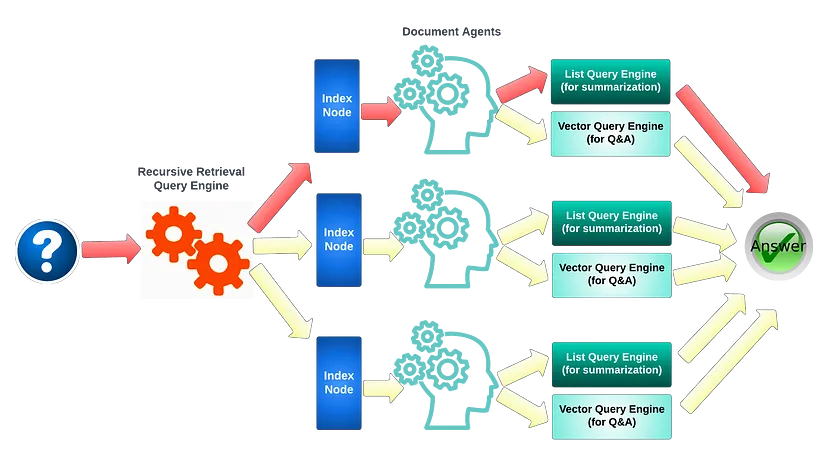

In [ ]:
from llama_index.core import (
    VectorStoreIndex,
    SummaryIndex,
    Response
)
from llama_index.core.schema import IndexNode
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.llms.openai import OpenAI
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import get_response_synthesizer
from llama_index.agent.openai import OpenAIAgent
import pandas as pd
import openai
import os


In [ ]:
#define LLM
llm = OpenAI(temperature=0.1, model_name="gpt-3.5-turbo")

### Create document agents

In [ ]:
# Build agents dictionary
agents = {}

for title in titles:

    # build vector index
    vector_index = VectorStoreIndex.from_documents(documents[title])

    # build summary index
    list_index = SummaryIndex.from_documents(documents[title])

    # define query engines
    vector_query_engine = vector_index.as_query_engine(llm=llm)
    list_query_engine = list_index.as_query_engine(llm=llm)

    # define tools
    query_engine_tools = [
        QueryEngineTool(
            query_engine=vector_query_engine,
            metadata=ToolMetadata(
                name="vector_tool",
                description=f"Useful for retrieving specific context related to {title}",
            ),
        ),
        QueryEngineTool(
            query_engine=list_query_engine,
            metadata=ToolMetadata(
                name="summary_tool",
                description=f"Useful for summarization questions related to {title}",
            ),
        ),
    ]

    # build agent
    function_llm = OpenAI(model="gpt-3.5-turbo-0613")
    agent = OpenAIAgent.from_tools(
        query_engine_tools,
        llm=function_llm,
        verbose=False,
    )

    agents[title] = agent

### Create index nodes

In [ ]:
# define index nodes that link to the document agents
nodes = []
for title in titles:
    doc_summary = (
        f"This content contains details about {title}. "
        f"Use this index if you need to lookup specific facts about {title}.\n"
        "Do not use this index if you want to query multiple documents."
    )
    node = IndexNode(text=doc_summary, index_id=title)
    nodes.append(node)

# define retriever
vector_index = VectorStoreIndex(nodes)
vector_retriever = vector_index.as_retriever(similarity_top_k=1)

### Define recursive retriever and query engine

In [ ]:
# define recursive retriever
# note: can pass `agents` dict as `query_engine_dict` since every agent can be used as a query engine
recursive_retriever = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever},
    query_engine_dict=agents,
    verbose=False,
)

response_synthesizer = get_response_synthesizer(response_mode="compact")

# define query engine
recursive_query_engine = RetrieverQueryEngine.from_args(
    recursive_retriever,
    response_synthesizer=response_synthesizer,
    llm=llm,
)

### Run test queries

In [ ]:
response = recursive_query_engine.query("Give me a summary of DevOps self-service-centric pipeline security and guardrails.")
print(str(response))

DevOps self-service-centric pipeline security and guardrails are essential for maintaining the security and reliability of DevOps processes. These practices involve implementing security measures and guardrails in a centralized repository to protect pipelines from potential threats and vulnerabilities. This includes detecting and preventing sensitive information leaks, scanning source code for security vulnerabilities, and ensuring the security of base images. By incorporating these tools and practices, organizations can establish robust security measures and guardrails to protect their infrastructure and applications, ensuring the reliability and security of their DevOps processes.


In [ ]:
response = recursive_query_engine.query("What is Harden Runner in DevOps self-service-centric pipeline security and guardrails?")
print(str(response))

Harden Runner in DevOps self-service-centric pipeline security and guardrails refers to the process of securing the runner environment used in CI/CD pipelines. This involves implementing security measures to protect the runner environment from potential vulnerabilities and attacks, such as configuring access controls, applying security patches and updates, using secure communication protocols, and implementing authentication and authorization mechanisms. By hardening the runner environment, organizations can ensure that the execution of pipeline tasks and jobs is done in a secure and controlled manner, reducing the risk of unauthorized access, data breaches, and other security incidents.


## Metadata Replacement + Node Sentence Window

SentenceWindowNodeParser is a tool that can be used to create representations of sentences that consider the surrounding words and sentences. During retrieval, before passing the retrieved sentences to the LLM, the single sentences are replaced with a window containing the surrounding sentences using the MetadataReplacementNodePostProcessor. This can be useful for tasks such as machine translation or summarization, where it is essential to understand the meaning of the sentence in its entirety. This is most useful for large documents, as it helps to retrieve more fine-grained details.

Image source: https://twitter.com/jerryjliu0/status/1708147687084986504

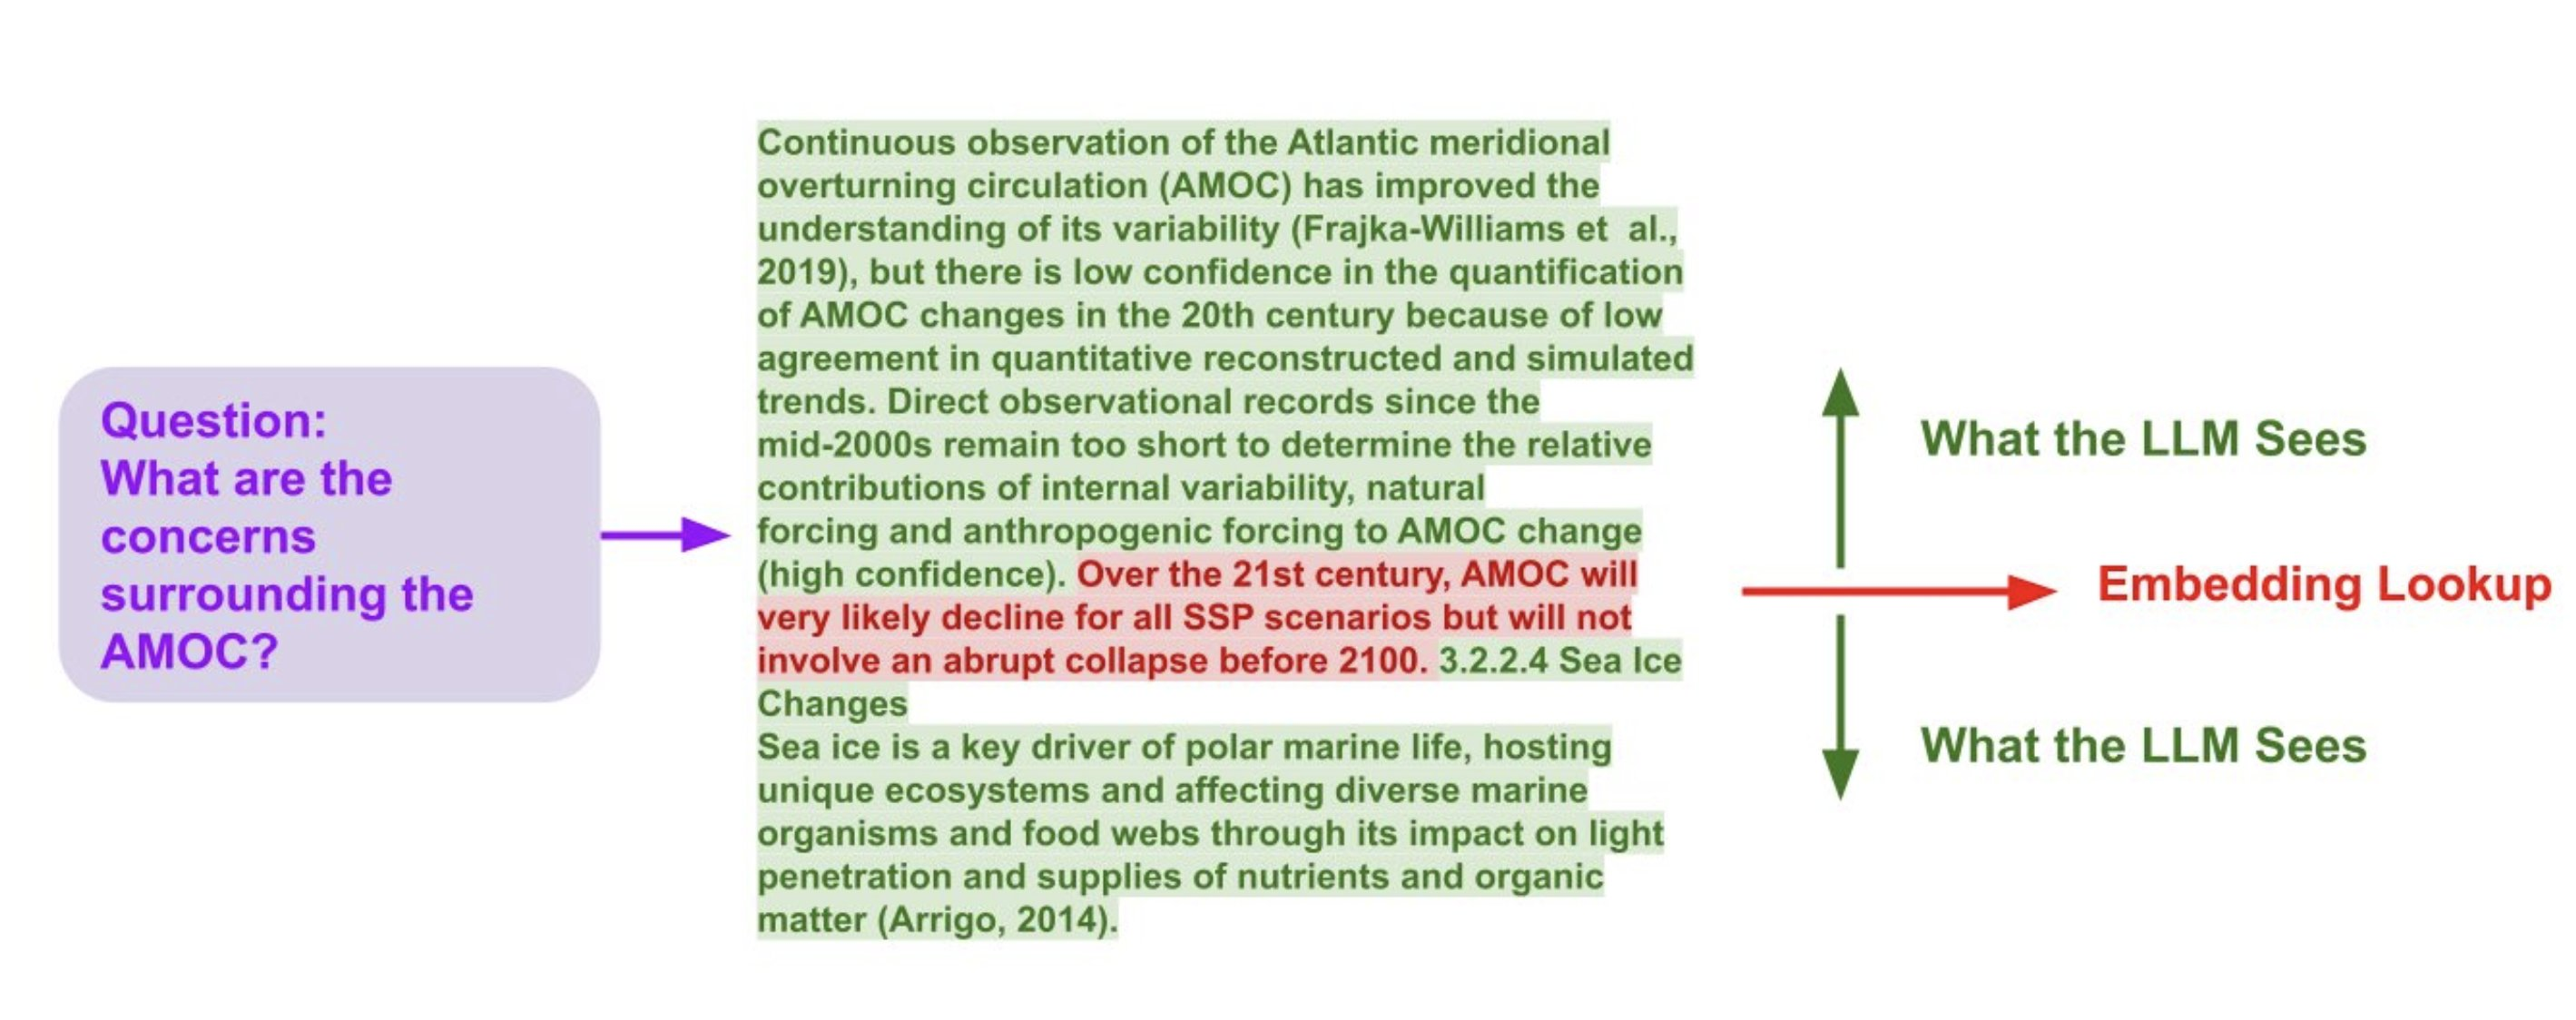

### Set up node parser

In [ ]:
from llama_index.core import set_global_service_context
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceWindowNodeParser, SimpleNodeParser

# create the sentence window node parser
node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=3,
    window_metadata_key="window",
    original_text_metadata_key="original_text",
)
simple_node_parser = SimpleNodeParser.from_defaults()

llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)
embed_model = HuggingFaceEmbedding(
    model_name="sentence-transformers/all-mpnet-base-v2", max_length=512
)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

### Extract nodes and build index

In [ ]:
from llama_index.core import VectorStoreIndex

document_list = SimpleDirectoryReader("data").load_data()
nodes = node_parser.get_nodes_from_documents(document_list)
sentence_index = VectorStoreIndex(nodes, embed_model=embed_model)

### Define query engine

In [ ]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

metadata_query_engine = sentence_index.as_query_engine(
    similarity_top_k=2,
    llm=llm,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ],
)

### Run test queries

In [ ]:
query = "Give me a summary of DevOps self-service-centric pipeline security and guardrails."
response = metadata_query_engine.query(query)
print(str(response))

DevOps self-service-centric pipeline security and guardrails involve implementing a list of hand-picked actions to ensure the security and compliance of pipelines, infrastructure, source code, base images, and dependent libraries. These actions are implemented in reusable workflows for both infrastructure and application pipelines, and developers are required to adhere to them when developing workflows for their applications. The goal is to provide a self-service environment where developers can confidently build and deploy their applications while maintaining security and compliance standards.


In [ ]:
query = "What is Harden Runner in DevOps self-service-centric pipeline security and guardrails?"
response = metadata_query_engine.query(query)
print(str(response))

Harden-Runner is a purpose-built security monitoring agent for pipelines in DevOps self-service-centric pipeline security and guardrails. It is designed to detect and prevent malicious patterns that have been observed during past software supply chain security breaches. Some of the main features of Harden-Runner include automatically discovering and correlating outbound traffic with each step in the pipeline, preventing the exfiltration of credentials in the pipeline, and detecting tampering of source code during the build.


## Evaluations

1. Use DatasetGenerator to auto-generate 30 evaluation
questions.
2. Define evaluators for faithfulness and relevancy.
3. Use BatchEvalRunner to asynchronously run evaluations of the responses from the two query engines from the two strategies.
4. Compare the evaluation results and choose the strategy that scores better.




### Generate evaluation questions

In [ ]:
import random
random.seed(42)
from llama_index.core.evaluation import DatasetGenerator
import nest_asyncio

nest_asyncio.apply()

# load data
document_list = SimpleDirectoryReader("data").load_data()

question_dataset = []
if os.path.exists("question_dataset.txt"):
    with open("question_dataset.txt", "r") as f:
        for line in f:
            question_dataset.append(line.strip())
else:
    # generate questions
    data_generator = DatasetGenerator.from_documents(document_list)
    generated_questions = data_generator.generate_questions_from_nodes()
    print(f"Generated {len(generated_questions)} questions.")

    # randomly pick 30 questions
    generated_questions = random.sample(generated_questions, 30)
    question_dataset.extend(generated_questions)
    print(f"Randomly picked {len(question_dataset)} questions.")

    # save the questions into a txt file
    with open("question_dataset.txt", "w") as f:
        for question in question_dataset:
            f.write(f"{question.strip()}\n")

for i, question in enumerate(question_dataset, start=1):
    print(f"{i}. {question}")

/usr/local/lib/python3.10/dist-packages/llama_index/core/evaluation/dataset_generation.py:212: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be used instead.)
  return cls(


Generated 490 questions.
Randomly picked 30 questions.
1. Who is the author of the document?
2. What is the file name of the document?
3. What is the 3-2-1 rule in the context of the self-service pipeline architecture?
4. What are the potential drawbacks of having all Terraform code for all projects committed in one standalone repository?
5. What is the purpose of Infracost in a DevOps environment?
6. How can you enable block mode in Harden-Runner?
7. How large is the file "DevOps_Self-Service_Pipeline_Security_Guardrails.pdf" in terms of file size?
8. How can GitHub Actions' workflows be orchestrated in a self-service centric manner?
9. What is the purpose of the "main.tf" file in a reusable module?
10. Where is the Terraform code and GitHub Actions workflow code located?
11. What is the role of the red highlighted rectangle in the provided diagram?
12. What determines the branch on which the "terraform apply" step is executed?
13. What is the significance of the creation date and las

/usr/local/lib/python3.10/dist-packages/llama_index/core/evaluation/dataset_generation.py:309: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return QueryResponseDataset(queries=queries, responses=responses_dict)


### Define evaluators

In [ ]:
from llama_index.core.evaluation import FaithfulnessEvaluator, RelevancyEvaluator

# use gpt-4 to evaluate
llm=OpenAI(temperature=0.1, llm="gpt-4")

faithfulness_gpt4 = FaithfulnessEvaluator(llm=llm)
relevancy_gpt4 = RelevancyEvaluator(llm=llm)

### Define evaluation batch runner

In [ ]:
from llama_index.core.evaluation import BatchEvalRunner

runner = BatchEvalRunner(
    {"faithfulness": faithfulness_gpt4, "relevancy": relevancy_gpt4},
    workers=10,
    show_progress=True
)

Be mindful not to define workers to be too high, as it may run into rate limit issues with OpenAI.

In [ ]:
def get_eval_results(key, eval_results):
    results = eval_results[key]
    correct = 0
    for result in results:
        if result.passing:
            correct += 1
    score = correct / len(results)
    print(f"{key} Correct: {correct}. Score: {score}")
    return score

### Evaluation of recursive retriever + document agent

In [ ]:
eval_results = await runner.aevaluate_queries(
    recursive_query_engine, queries=question_dataset
)

print("------------------")
score = get_eval_results("faithfulness", eval_results)
score = get_eval_results("relevancy", eval_results)

100%|██████████| 60/60 [01:05<00:00,  1.09s/it]

------------------
faithfulness Correct: 29. Score: 0.9666666666666667
relevancy Correct: 29. Score: 0.9666666666666667


### Evaluation of metadata replacement + node sentence window

In [ ]:
eval_results = await runner.aevaluate_queries(
    metadata_query_engine, queries=question_dataset
)

print("------------------")
score = get_eval_results("faithfulness", eval_results)
score = get_eval_results("relevancy", eval_results)

100%|██████████| 60/60 [00:03<00:00, 18.48it/s]

------------------
faithfulness Correct: 25. Score: 0.8333333333333334
relevancy Correct: 19. Score: 0.6333333333333333


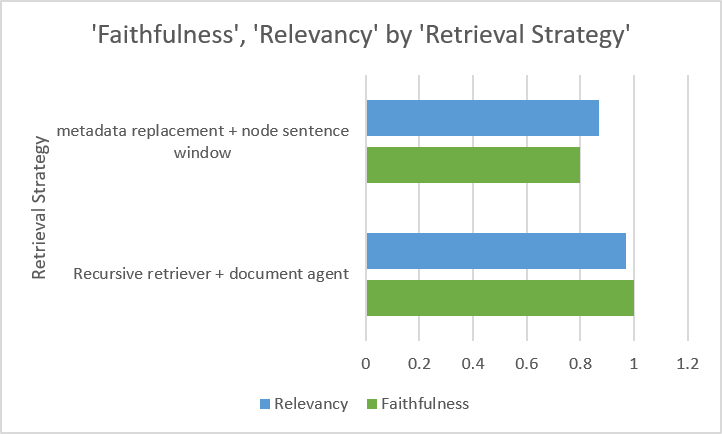